In [54]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [55]:
df_clean = pd.read_csv('../data/data_clean.csv')
print(df_clean.columns)
# encode primary_type as integer class labels and replace the column with class_primary
labels, uniques = pd.factorize(df_clean['primary_type'])
df_clean['class_primary'] = labels.astype(int)
mapping = {v: i for i, v in enumerate(uniques)}
df_clean.drop(columns=['primary_type'], inplace=True)

print("class_primary mapping:", mapping)
print(df_clean[['class_primary']].head())

Index(['gen', 'primary_type', 'secondary_type', 'percent_male',
       'percent_female', 'height_m', 'weight_kg', 'capture_rate',
       'base_egg_steps', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense',
       'speed', 'against_normal', 'against_fire', 'against_water',
       'against_electric', 'against_grass', 'against_ice', 'against_fighting',
       'against_poison', 'against_ground', 'against_flying',
       'against_psychict', 'against_bug', 'against_rock', 'against_ghost',
       'against_dragon', 'against_dark', 'against_steel', 'against_fairy',
       'num_abilities', 'evo_length', 'has_mega_evolution', 'has_gigantamax',
       'rarity'],
      dtype='object')
class_primary mapping: {'grass': 0, 'fire': 1, 'water': 2, 'bug': 3, 'normal': 4, 'poison': 5, 'electric': 6, 'ground': 7, 'fairy': 8, 'fighting': 9, 'psychic': 10, 'rock': 11, 'ghost': 12, 'ice': 13, 'dragon': 14, 'dark': 15, 'steel': 16, 'flying': 17}
   class_primary
0              0
1              0
2          

In [56]:
df_labels = df_clean.copy()[['class_primary','secondary_type','attack']]
df_data = df_clean.drop(columns=['class_primary','secondary_type','attack'])

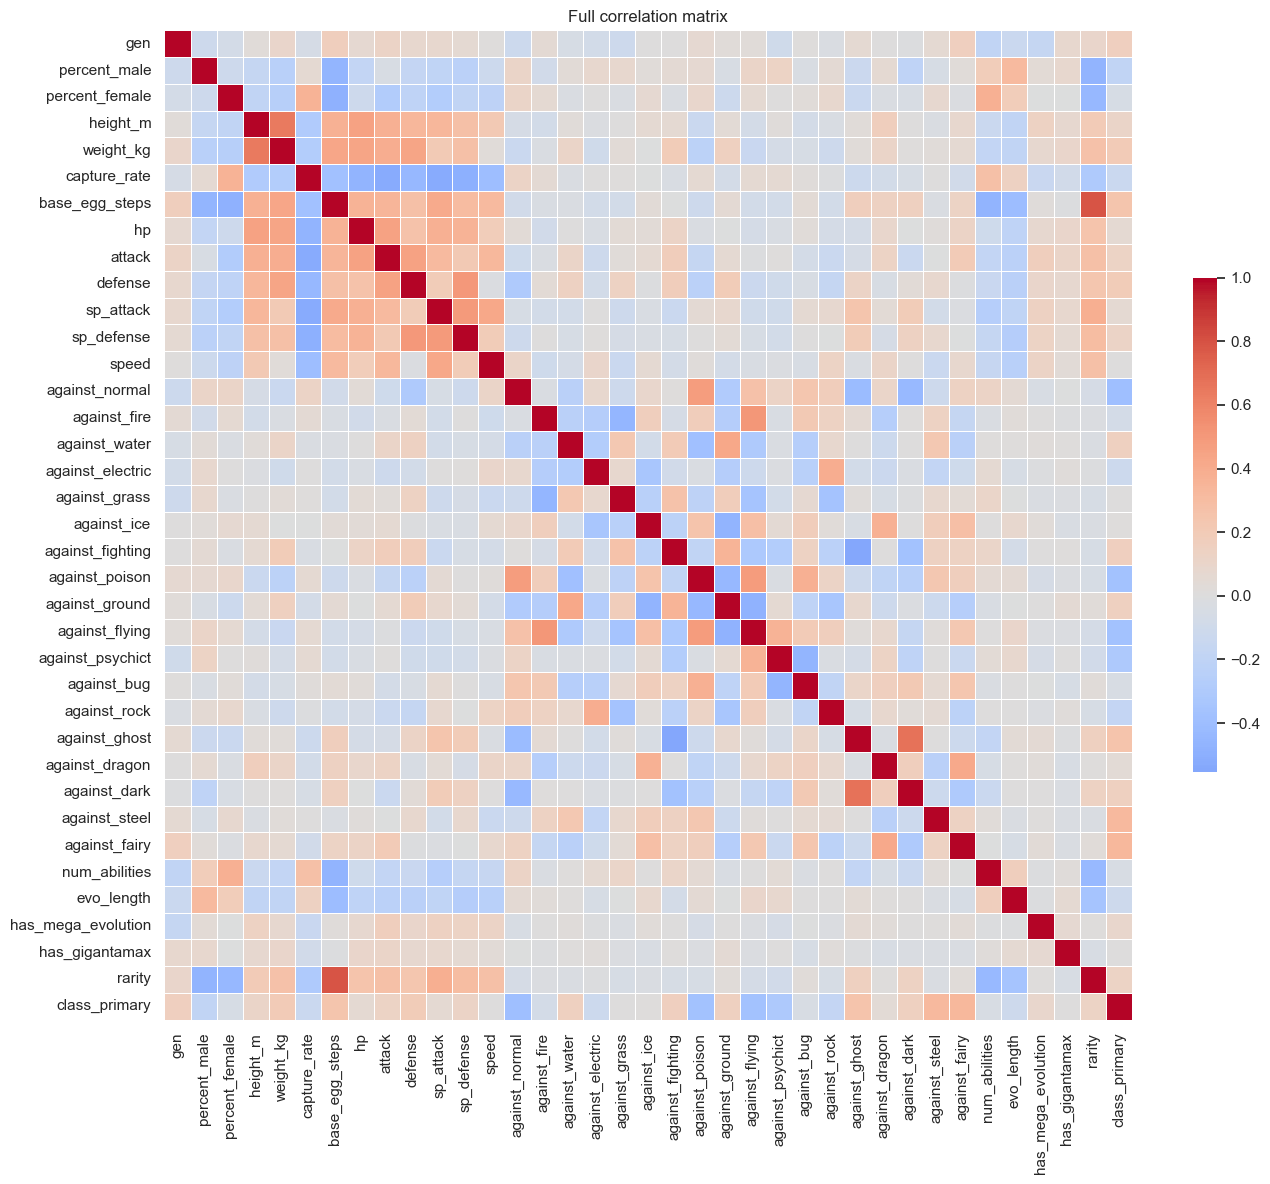

Top correlated variable pairs (by absolute correlation):
            var1           var2  abs_corr
  base_egg_steps         rarity  0.790583
   against_ghost   against_dark  0.676126
        height_m      weight_kg  0.642715
against_fighting  against_ghost  0.554569
    capture_rate      sp_attack  0.522649
    capture_rate         attack  0.520709
    against_fire against_flying  0.510980
         defense     sp_defense  0.507367
    capture_rate     sp_defense  0.499831
       sp_attack     sp_defense  0.491907
  against_poison against_flying  0.488559
  percent_female base_egg_steps  0.481715
  against_ground against_flying  0.480854
  against_normal against_poison  0.478127
     against_ice against_ground  0.473085
    capture_rate             hp  0.470610
  base_egg_steps  num_abilities  0.467755
    percent_male         rarity  0.466875
against_psychict    against_bug  0.461637
    percent_male base_egg_steps  0.458000


In [57]:
# compute correlation matrix for all numeric parameters
numeric = df_clean.select_dtypes(include=[np.number])
corr = numeric.corr()

plt.figure(figsize=(14, 12))
sns.set(style="white")
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": .5})
plt.title("Full correlation matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=150)
plt.show()

# show top absolute correlations (excluding self-correlations) as a quick summary
abs_corr = corr.abs()
pairs = (
    abs_corr.unstack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'abs_corr'})
)
pairs = pairs[pairs['var1'] != pairs['var2']]
# keep unique pairs (unordered) and sort by absolute correlation
pairs['pair_key'] = pairs.apply(lambda r: tuple(sorted((r['var1'], r['var2']))), axis=1)
top_pairs = pairs.drop_duplicates(subset='pair_key').sort_values('abs_corr', ascending=False)

print("Top correlated variable pairs (by absolute correlation):")
print(top_pairs[['var1', 'var2', 'abs_corr']].head(20).to_string(index=False))

C:\Users\jenda\AppData\Local\Temp\ipykernel_5544\3920045475.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=temp['gen_int'], y=df_labels['attack'], palette="Set3")


Attack quantiles by generation:
          0.00   0.25  0.50    0.75   1.00
gen_int                                  
1         5.0  51.00  70.0   92.00  134.0
2        10.0  49.75  67.5   85.00  134.0
3        15.0  50.00  70.0   90.00  160.0
4         5.0  60.00  80.0  100.00  165.0
5        25.0  55.00  77.5  100.00  150.0
6        22.0  52.00  69.0   90.50  131.0
7        20.0  60.00  76.5  112.25  181.0
8        20.0  60.00  85.0  100.00  145.0


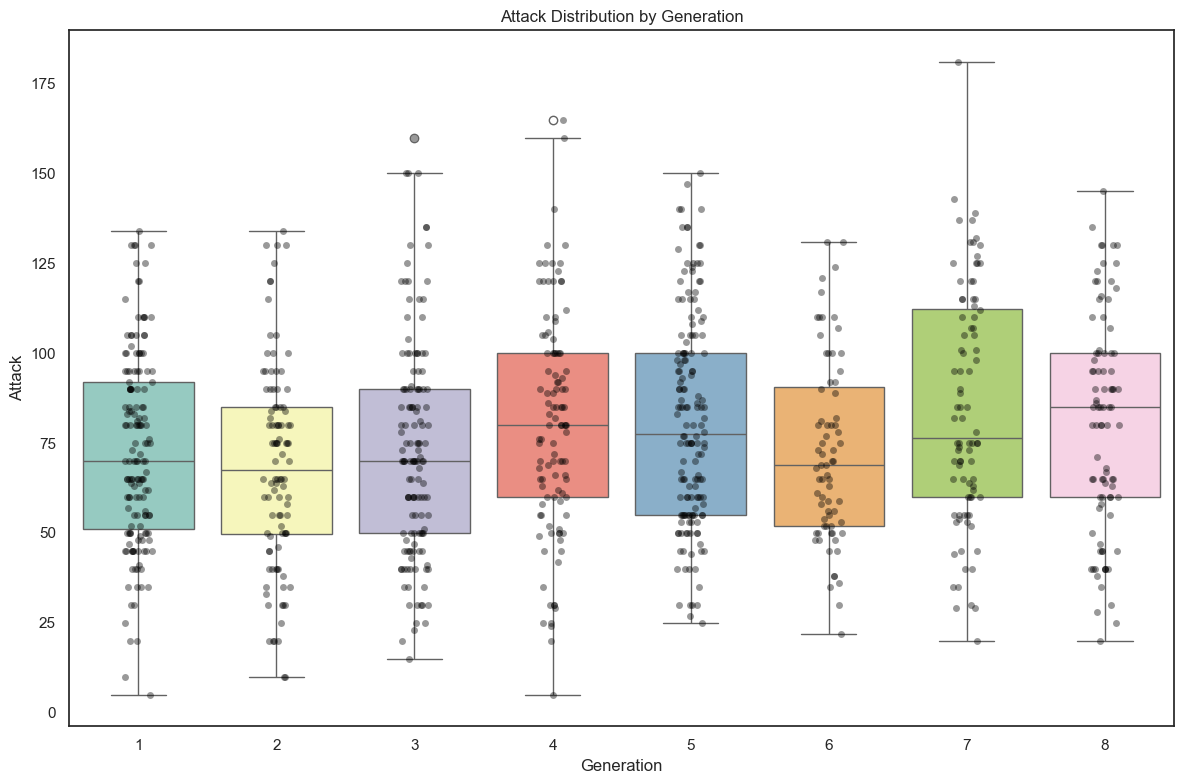

In [58]:
temp = pd.DataFrame()
temp['gen_int'] = df_data['gen'].astype(int)
temp['rarity'] = df_data['rarity']


plt.figure(figsize=(12, 8))
sns.boxplot(x=temp['gen_int'], y=df_labels['attack'], palette="Set3")
sns.stripplot(x=temp['gen_int'], y=df_labels['attack'], color='black', alpha=0.4, jitter=True)

# Calculate and print quantiles for each generation
quantiles = df_labels.groupby(temp['gen_int'])['attack'].quantile([0, 0.25, 0.5, 0.75, 1]).unstack()
print("Attack quantiles by generation:\n", quantiles)

plt.title("Attack Distribution by Generation")
plt.xlabel("Generation")
plt.ylabel("Attack")
plt.tight_layout()
plt.show()

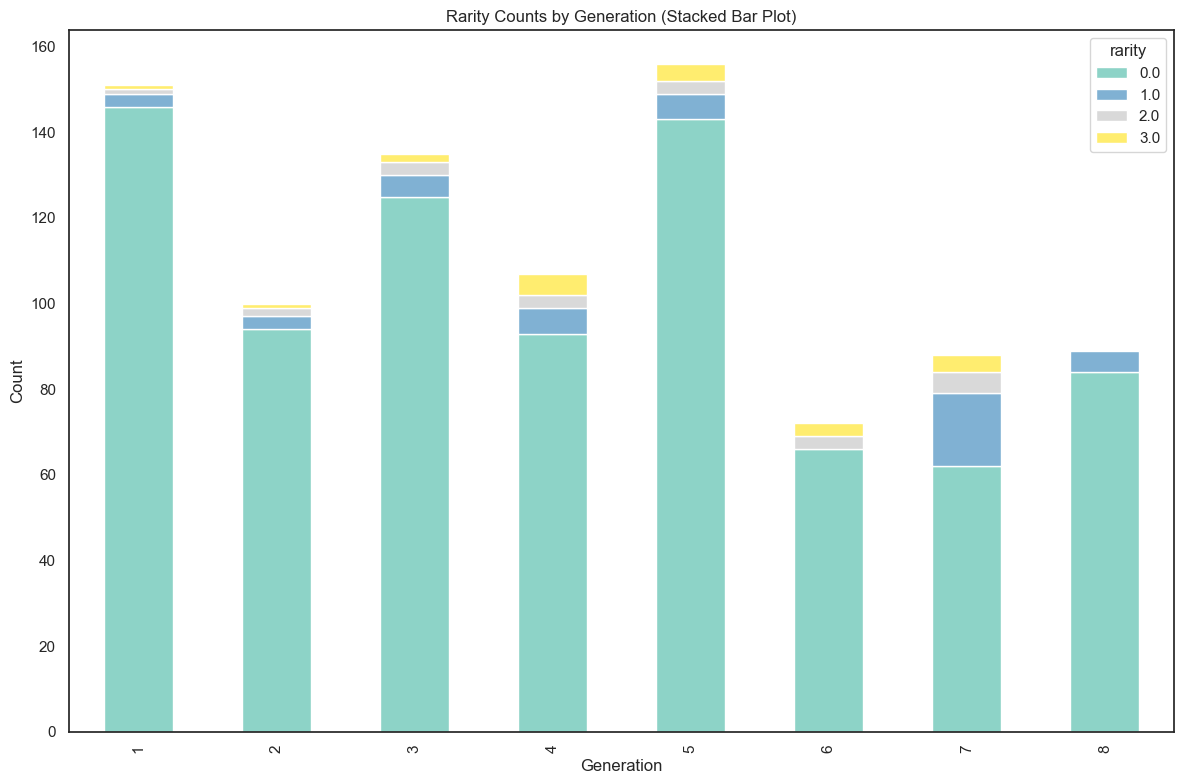

In [59]:
plt.figure(figsize=(12, 8))
rarity_counts = temp.groupby(['gen_int', 'rarity']).size().unstack(fill_value=0)
rarity_counts.plot(kind='bar', stacked=True, colormap='Set3', ax=plt.gca())

plt.title("Rarity Counts by Generation (Stacked Bar Plot)")
plt.xlabel("Generation")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


outlier
 1    853
-1     45
Name: count, dtype: int64


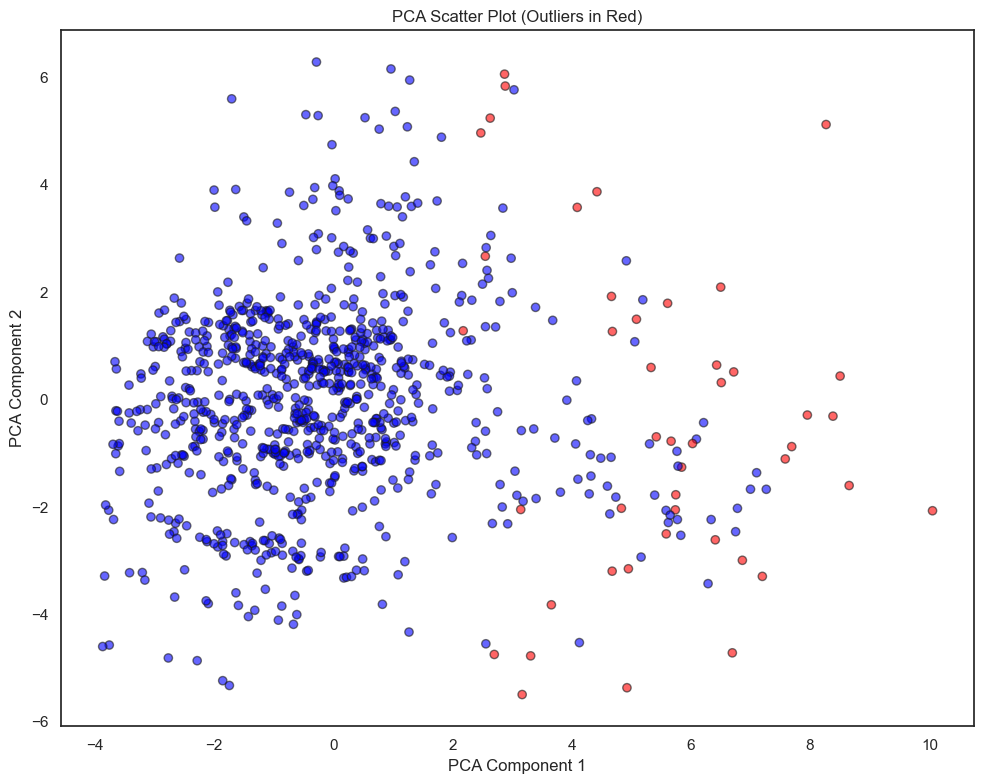

In [60]:
# Standardize all features in df_plot
scaler= StandardScaler()
pca = PCA(n_components=2)

df_plot_scaled = pd.DataFrame(scaler.fit_transform(df_data), columns=df_data.columns)
pca.fit(df_plot_scaled)

# Fit Isolation Forest for outlier detection
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df_plot_scaled)

# Add outlier flag to dataframe: -1 is outlier, 1 is inlier
df_plot_scaled['outlier'] = outlier_pred
print(df_plot_scaled['outlier'].value_counts())

pca_data = pca.transform(df_plot_scaled.drop(columns=['outlier']))
plt.figure(figsize=(10, 8))
colors = np.where(df_plot_scaled['outlier'] == -1, 'red', 'blue')
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=colors, alpha=0.6, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Scatter Plot (Outliers in Red)')
plt.tight_layout()
plt.show()

In [61]:
# Rarity of outliers
outlier_mask = outlier_pred == -1
rarity_outliers = temp.loc[outlier_mask, 'rarity']
rarity_full = temp['rarity']

# Count and percentage for outliers
outlier_counts = rarity_outliers.value_counts().sort_index()
outlier_percent = (outlier_counts / len(rarity_outliers) * 100).round(2)

print("Outlier rarity counts:\n", outlier_counts)
print("Outlier rarity percentages (%):\n", outlier_percent)

# Count and percentage for full population
full_counts = rarity_full.value_counts().sort_index()
full_percent = (full_counts / len(rarity_full) * 100).round(2)

print("\nFull population rarity counts:\n", full_counts)
print("Full population rarity percentages (%):\n", full_percent)

Outlier rarity counts:
 rarity
0.0    12
1.0    14
2.0    10
3.0     9
Name: count, dtype: int64
Outlier rarity percentages (%):
 rarity
0.0    26.67
1.0    31.11
2.0    22.22
3.0    20.00
Name: count, dtype: float64

Full population rarity counts:
 rarity
0.0    813
1.0     45
2.0     20
3.0     20
Name: count, dtype: int64
Full population rarity percentages (%):
 rarity
0.0    90.53
1.0     5.01
2.0     2.23
3.0     2.23
Name: count, dtype: float64


In [62]:

# Prepare features and target
X = df_data
y = df_labels['attack']

# Add constant for intercept
X_const = sm.add_constant(X.select_dtypes(include=[np.number]))

# Fit OLS linear regression
model = sm.OLS(y, X_const).fit()

# Show model summary
print(model.summary())
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("Variance Inflation Factor (VIF) for each variable:")
print(vif_data.sort_values('VIF', ascending=False))

                            OLS Regression Results                            
Dep. Variable:                 attack   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     32.47
Date:                Tue, 21 Oct 2025   Prob (F-statistic):          1.82e-132
Time:                        22:17:25   Log-Likelihood:                -3940.4
No. Observations:                 898   AIC:                             7953.
Df Residuals:                     862   BIC:                             8126.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.8798     13

In [63]:
# Drop 'against_dragon' from X_const and recalculate VIF
X_const_vif = X_const.drop(columns=['against_dragon','against_flying','against_ground','base_egg_steps','against_dark','against_fighting'])

vif_data_new = pd.DataFrame()
vif_data_new["feature"] = X_const_vif.columns
vif_data_new["VIF"] = [variance_inflation_factor(X_const_vif.values, i) for i in range(X_const_vif.shape[1])]

print("Variance Inflation Factor (VIF) after dropping 'against_dragon':")
print(vif_data_new.sort_values('VIF', ascending=False))

Variance Inflation Factor (VIF) after dropping 'against_dragon':
               feature         VIF
0                const  199.879226
15    against_electric    2.549668
14       against_water    2.536700
20         against_bug    2.345968
6         capture_rate    2.345850
5            weight_kg    2.238441
21        against_rock    2.206333
12      against_normal    2.199744
18      against_poison    2.123869
29              rarity    2.122422
9            sp_attack    2.112914
8              defense    2.107672
13        against_fire    2.106768
4             height_m    2.080703
10          sp_defense    1.973619
16       against_grass    1.886573
2         percent_male    1.819162
3       percent_female    1.798221
7                   hp    1.793196
19    against_psychict    1.705830
11               speed    1.636066
24       against_fairy    1.610932
23       against_steel    1.570555
22       against_ghost    1.551364
17         against_ice    1.500160
25       num_abilities   

In [64]:
# Refit OLS linear regression using X_const_vif and attack as target
model_vif = sm.OLS(y, X_const_vif).fit()
print(model_vif.summary())

                            OLS Regression Results                            
Dep. Variable:                 attack   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     37.53
Date:                Tue, 21 Oct 2025   Prob (F-statistic):          5.42e-132
Time:                        22:17:25   Log-Likelihood:                -3953.0
No. Observations:                 898   AIC:                             7966.
Df Residuals:                     868   BIC:                             8110.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 21.0980      9

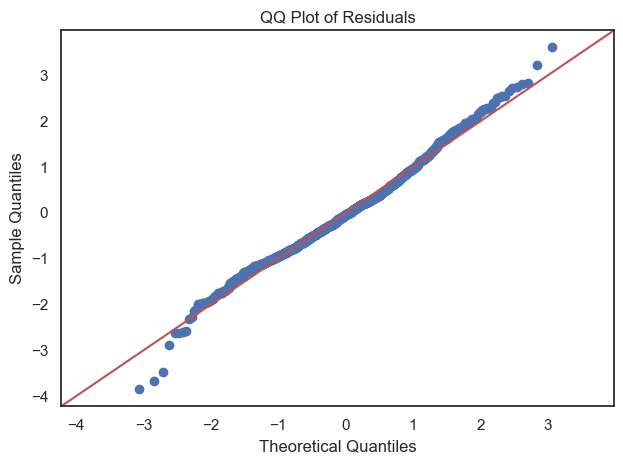

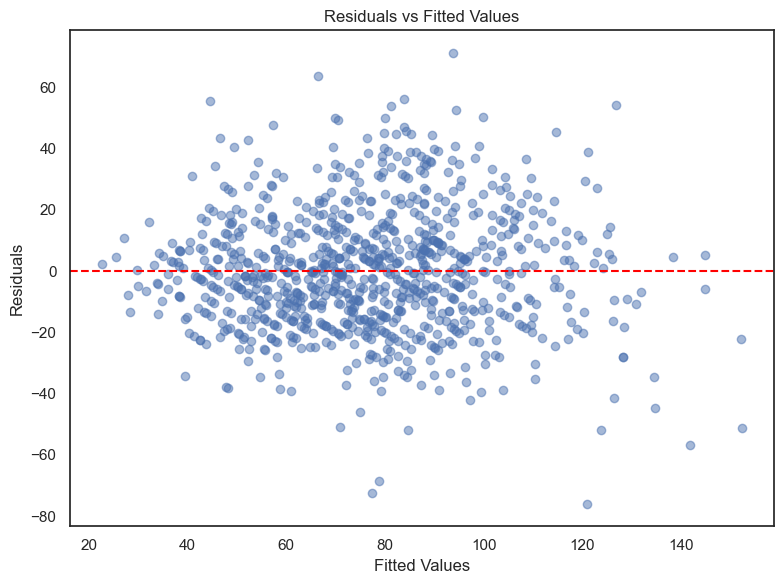

In [65]:
# QQ plot of residuals
residuals = model_vif.resid
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()

# Residual plot (fitted values vs residuals)
fitted = model_vif.fittedvalues
plt.figure(figsize=(8, 6))
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 attack   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     59.70
Date:                Tue, 21 Oct 2025   Prob (F-statistic):          1.16e-138
Time:                        22:17:26   Log-Likelihood:                -3959.3
No. Observations:                 898   AIC:                             7957.
Df Residuals:                     879   BIC:                             8048.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.1665      7

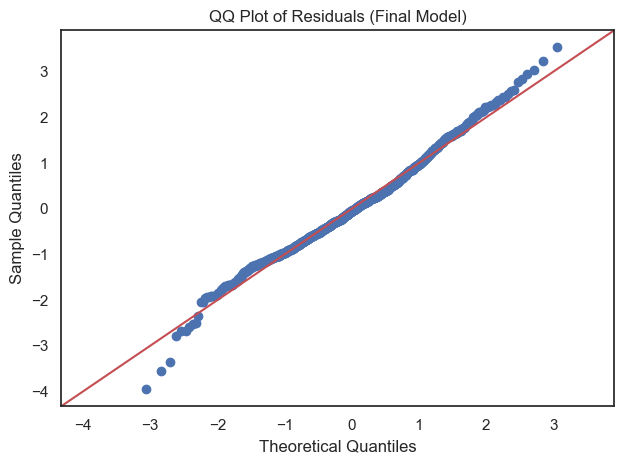

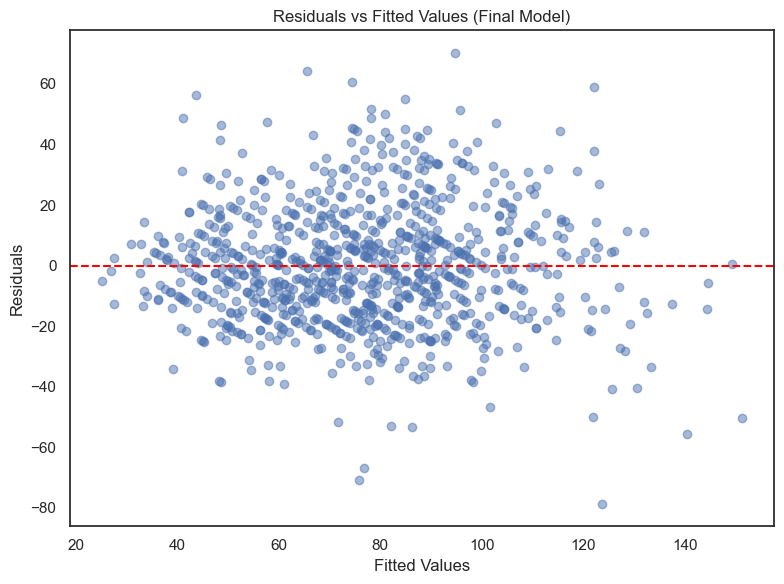

Variance Inflation Factor (VIF) for final model variables:
               feature         VIF
0                const  125.203224
4         capture_rate    2.164372
7            sp_attack    1.966386
6              defense    1.944943
8           sp_defense    1.883570
5                   hp    1.647604
18              rarity    1.587736
9                speed    1.527761
3            weight_kg    1.516425
2         percent_male    1.458391
16          evo_length    1.318623
15       against_fairy    1.296667
11       against_water    1.279404
10        against_fire    1.224415
14       against_ghost    1.198343
13        against_rock    1.181106
1                  gen    1.110610
17  has_mega_evolution    1.097428
12    against_psychict    1.076503


In [66]:
# Drop specified columns from X_const_vif
cols_to_drop = [
    'percent_female', 'height_m', 'against_normal', 'against_electric',
    'against_grass', 'against_ice', 'against_poison', 'against_bug',
    'against_steel', 'has_gigantamax','num_abilities'
]
X_const_final = X_const_vif.drop(columns=cols_to_drop)

# Fit OLS linear regression
model_final = sm.OLS(y, X_const_final).fit()
print(model_final.summary())

# QQ plot of residuals
residuals_final = model_final.resid
sm.qqplot(residuals_final, line='45', fit=True)
plt.title("QQ Plot of Residuals (Final Model)")
plt.tight_layout()
plt.show()

# Residual plot (fitted values vs residuals)
fitted_final = model_final.fittedvalues
plt.figure(figsize=(8, 6))
plt.scatter(fitted_final, residuals_final, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Final Model)")
plt.tight_layout()
plt.show()

# VIF calculation
vif_final = pd.DataFrame()
vif_final["feature"] = X_const_final.columns
vif_final["VIF"] = [variance_inflation_factor(X_const_final.values, i) for i in range(X_const_final.shape[1])]
print("Variance Inflation Factor (VIF) for final model variables:")
print(vif_final.sort_values('VIF', ascending=False))

In [67]:
X = df_data
y = df_labels['class_primary']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
fold_acc = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train)
    X_val_scaled = scaler_fold.transform(X_val)

    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    print(f"Fold {i} accuracy: {acc:.4f}")
    fold_acc.append(acc)

print(f"Mean CV accuracy: {np.mean(fold_acc):.4f} (+/- {np.std(fold_acc):.4f})")

Fold 1 accuracy: 0.9222
Fold 2 accuracy: 0.9167
Fold 3 accuracy: 0.8667
Fold 4 accuracy: 0.9050
Fold 5 accuracy: 0.9162
Mean CV accuracy: 0.9054 (+/- 0.0201)
